In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 79.1 MB/s eta 0:00:00:00:0100:01


In [4]:
import os
import rasterio
import numpy as np
from PIL import Image

image_folder = '/kaggle/input/water-seg-data/data/images'  
label_folder = '/kaggle/input/water-seg-data/data/labels'  

# Lists to store data
X = []
y = []

for filename in os.listdir(image_folder):
    if filename.endswith('.tif'):
        # Get corresponding label filename
        label_filename = filename.replace('.tif', '.png')
        
        # Read TIF file with all bands
        with rasterio.open(os.path.join(image_folder, filename)) as src:
            image = src.read()  # This will read all bands
            # Transpose from (C, H, W) to (H, W, C)
            image = np.transpose(image, (1, 2, 0))
            
        # Read PNG label
        label = np.array(Image.open(os.path.join(label_folder, label_filename)))
        # Convert label to binary
        label = (label > 0).astype(np.float32)
        
        X.append(image)
        y.append(label)

X = np.array(X)
y = np.array(y)

# Add channel dimension to labels
y = np.expand_dims(y, axis=-1)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)

Data shape: (306, 128, 128, 12)
Labels shape: (306, 128, 128, 1)


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, ReLU
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D, AveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

In [7]:
# Split into train, validation, and test sets (70%, 15%, 15%)
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (214, 128, 128, 12)
Validation set shape: (46, 128, 128, 12)
Test set shape: (46, 128, 128, 12)


In [8]:
X_train_rgb = X_train[:, :, :, [2,3,4]]  # Selecting channels 2,3,4
X_val_rgb = X_val[:, :, :, [2,3,4]]
X_test_rgb = X_test[:, :, :, [2,3,4]]

print("RGB Training data shape:", X_train_rgb.shape)
print("RGB Validation data shape:", X_val_rgb.shape)
print("RGB Test data shape:", X_test_rgb.shape)

RGB Training data shape: (214, 128, 128, 3)
RGB Validation data shape: (46, 128, 128, 3)
RGB Test data shape: (46, 128, 128, 3)


# Here i Used ResNet pretrained model as a back bone to DeepLabV3+

In [9]:
class ConvBlock(Layer):
    def __init__(self, filters=256, kernel_size=3, dilation_rate=1, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        
        self.net = Sequential([
            Conv2D(filters, kernel_size=kernel_size, padding='same', 
                  dilation_rate=dilation_rate, use_bias=False, 
                  kernel_initializer='he_normal'),
            BatchNormalization(), 
            ReLU()
        ])
    
    def call(self, X):
        return self.net(X)
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "dilation_rate": self.dilation_rate,
        }



In [10]:
def AtrousSpatialPyramidPooling(X):
    shape = X.shape
    
    # Image Pooling
    image_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name="ASPP-AvgPool")(X)
    image_pool = ConvBlock(kernel_size=1, name="ASPP-ImagePool-CB")(image_pool)
    image_pool = UpSampling2D(size=(shape[1], shape[2]), interpolation='bilinear', name="ASPP-ImagePool-UpSample")(image_pool)
    
    # Atrous Operations
    conv_1 = ConvBlock(kernel_size=1, dilation_rate=1, name="ASPP-CB-1")(X)
    conv_6 = ConvBlock(kernel_size=3, dilation_rate=6, name="ASPP-CB-6")(X)
    conv_12 = ConvBlock(kernel_size=3, dilation_rate=12, name="ASPP-CB-12")(X)
    conv_18 = ConvBlock(kernel_size=3, dilation_rate=18, name="ASPP-CB-18")(X)
    
    # Combine All
    combined = Concatenate(name="ASPP-Combine")([image_pool, conv_1, conv_6, conv_12, conv_18])
    processed = ConvBlock(kernel_size=1, name="ASPP-Net")(combined)
    
    return processed

In [12]:
def create_deeplabv3_plus(input_shape=(128, 128, 3), num_classes=1):
    # Input
    inputs = Input(shape=input_shape, name="InputLayer")
    
    # Base Model
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    
    # ASPP Phase
    DCNN = resnet50.get_layer('conv4_block6_2_relu').output
    ASPP = AtrousSpatialPyramidPooling(DCNN)
    ASPP = UpSampling2D(size=(4, 4), name="AtrousSpatial")(ASPP)
    
    # LLF Phase
    LLF = resnet50.get_layer('conv2_block3_2_relu').output
    LLF = ConvBlock(filters=48, kernel_size=1, name="LLF-ConvBlock")(LLF)
    
    # Combined
    combined = Concatenate(axis=-1, name="Combine-LLF-ASPP")([ASPP, LLF])
    features = ConvBlock(name="Top-ConvBlock-1")(combined)
    features = ConvBlock(name="Top-ConvBlock-2")(features)
    upsample = UpSampling2D(size=(4, 4), interpolation='bilinear', name="Top-UpSample")(features)
    
    # Output Mask
    outputs = Conv2D(num_classes, kernel_size=3, strides=1, padding='same', activation='sigmoid', use_bias=False, name="OutputMask")(upsample)
    
    return Model(inputs=inputs, outputs=outputs)


In [13]:
model = create_deeplabv3_plus()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
    ]
)

# Print model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)   │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ InputLayer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 11,854,144 (45.22 MB)

 Trainable params: 11,821,408 (45.10 MB)

 Non-trainable params: 32,736 (127.88 KB)

In [14]:
callbacks = [
    ModelCheckpoint(
        "best_deeplabv3plus_water.keras",
        save_best_only=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

In [15]:
history = model.fit(
    X_train_rgb,  # Using RGB data
    y_train,
    batch_size=16,
    epochs=100,
    validation_data=(X_val_rgb, y_val),  # Using RGB validation data
    callbacks=callbacks
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.7318 - io_u: 0.0000e+00 - loss: 0.5756 - val_accuracy: 0.7011 - val_io_u: 0.0000e+00 - val_loss: 1.4048 - learning_rate: 1.0000e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.8936 - io_u: 0.0029 - loss: 0.2721 - val_accuracy: 0.7549 - val_io_u: 0.0000e+00 - val_loss: 0.7811 - learning_rate: 1.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9132 - io_u: 0.0037 - loss: 0.2051 - val_accuracy: 0.7910 - val_io_u: 0.0000e+00 - val_loss: 0.4914 - learning_rate: 1.0000e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.9127 - io_u: 0.0030 - loss: 0.2075 - val_accuracy: 0.8149 - val_io_u: 0.0000e+00 - val_loss: 0.4032 - learning_rate: 1.0000e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9221 - io_u: 9.9157e-04 - loss: 0.1867 - val_accuracy: 0.8551 - val_io_u: 7.6124e-04 - val_loss: 0.3360 - learning_rate: 1.0000e-04
Epoch 6/100
14/14 ━

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred, threshold=0.5):
    # Ensure predictions are binary
    y_pred_binary = (y_pred > threshold).astype(np.float32)
    
    # Calculate IoU
    intersection = np.sum(y_true * y_pred_binary)
    union = np.sum(y_true) + np.sum(y_pred_binary) - intersection
    iou = intersection / (union + 1e-8)
    
    # Calculate Precision
    precision = intersection / (np.sum(y_pred_binary) + 1e-8)
    
    # Calculate Recall
    recall = intersection / (np.sum(y_true) + 1e-8)
    
    # Calculate F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    # Calculate Accuracy
    accuracy = np.sum(y_true == y_pred_binary) / (len(y_true.flatten()) + 1e-8)
    
    return {
        'IoU': iou,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Accuracy': accuracy
    }

In [21]:
test_predictions = model.predict(X_test_rgb) 

metrics = calculate_metrics(y_test, test_predictions)

# Print metrics
print("\nTest Set Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

Test Set Metrics:
IoU: 0.7893
Precision: 0.9225
Recall: 0.8454
F1: 0.8823
Accuracy: 0.9352


In [22]:
def visualize_predictions(X_rgb, y_true, y_pred, num_samples=5):
    # Select random samples
    indices = np.random.randint(0, len(X_rgb), num_samples)
    
    plt.figure(figsize=(15, 3*num_samples))
    for i, idx in enumerate(indices):
        # Original RGB image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X_rgb[idx])
        plt.title('RGB Image')
        plt.axis('off')
        
        # Ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y_true[idx, :, :, 0], cmap='binary')
        plt.title('Ground Truth')
        plt.axis('off')
        
        # Predicted mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(y_pred[idx, :, :, 0] > 0.5, cmap='binary')
        plt.title('Prediction')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

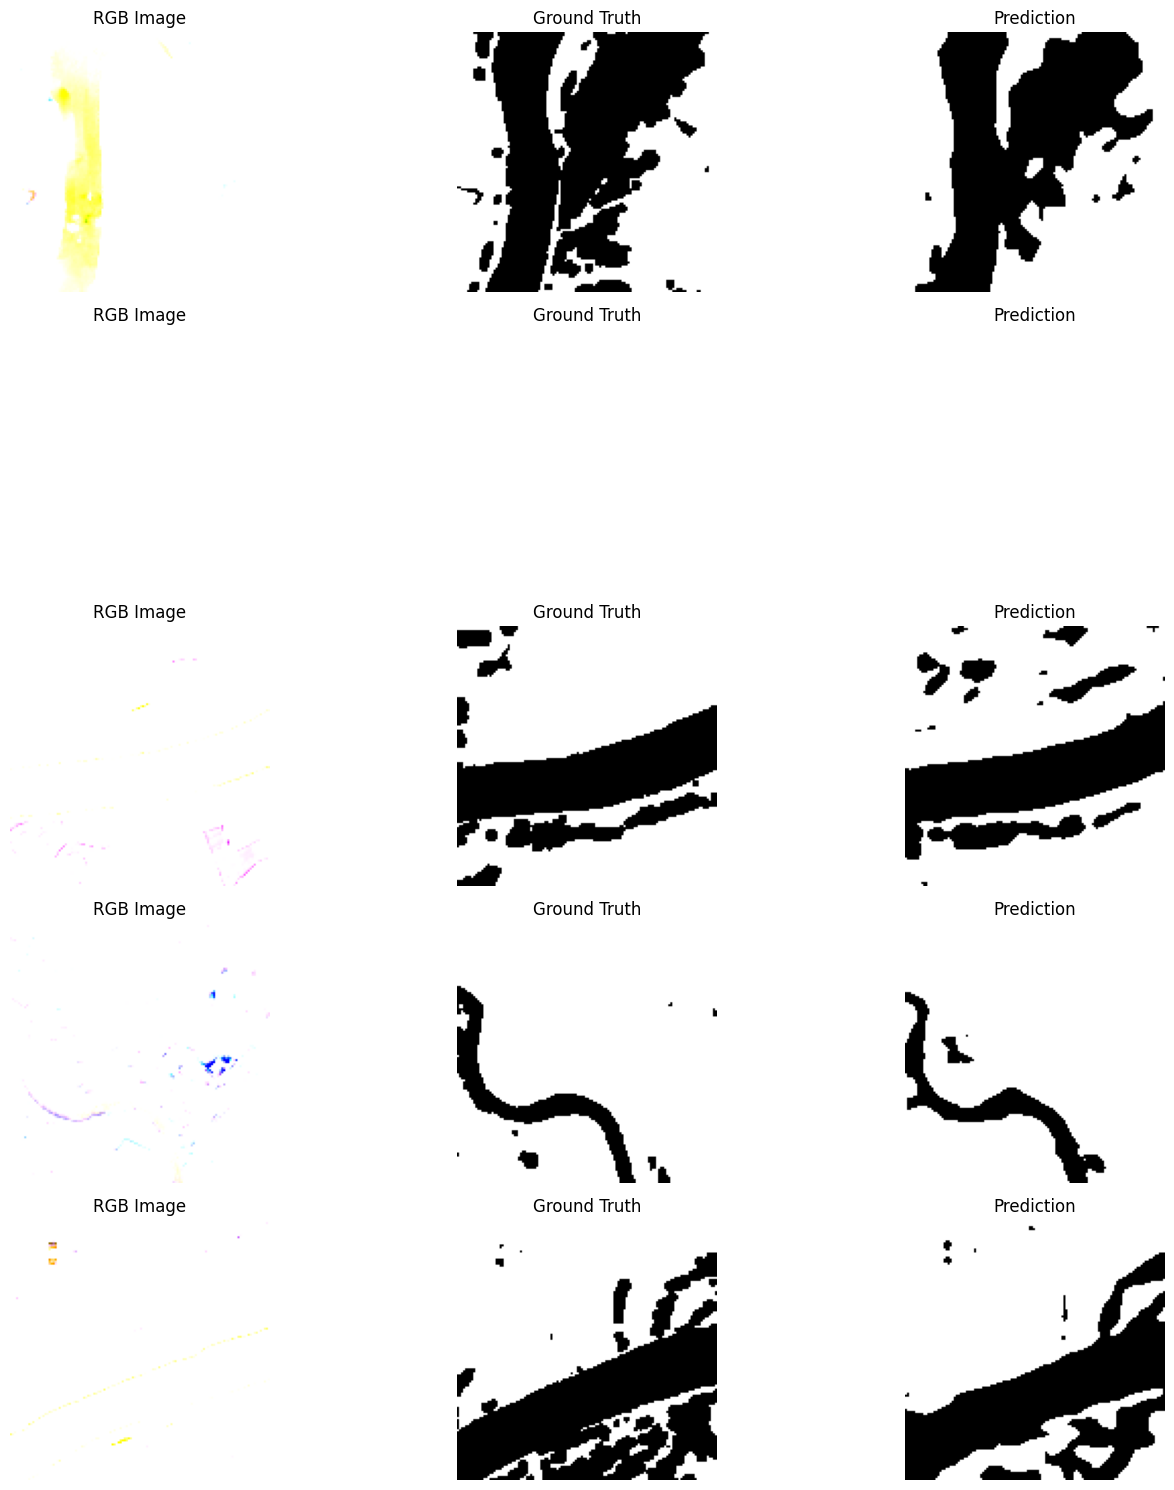

In [69]:
visualize_predictions(X_test_rgb, y_test, test_predictions)

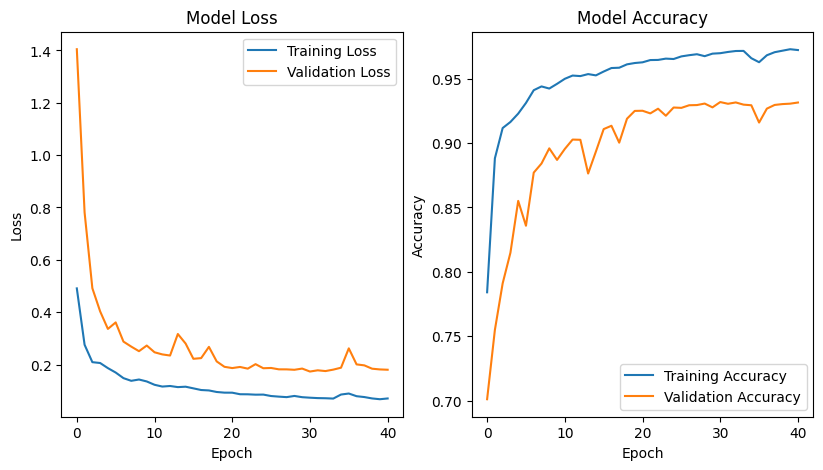

In [23]:
def plot_training_history(history):
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
plot_training_history(history)

In [24]:
model.save('water_segmentation_model.h5')